# Character Level RNN using LSTM cells.

- Trains on Star Trek episode titles
- Outputs "fake" titles.

Much comes from a [Keras example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

## Setup Environment

- Import Keras
- Open up the Star Trek corpus
- Give each leter an index and create dictionaries to translate from index to character.

In [2]:
## Much borrowed from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
import numpy as np
import random
import sys

text = open("../startrekepisodes.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print('total chars:', vocabulary_size)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


# How long is a title?
titles = text.split('\n')
lengths = np.array([len(n) for n in titles])
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Min:", np.min(lengths))

# hence choose 30 as seuence length to train on.

corpus length: 11010
total chars: 49
Max: 50
Mean: 14.0013623978
Median: 13.0
Min: 2


## Setup Training Data

- Cut up the corpus into sequences of 40 characters.
- Change indexes into "one-hot" vector encodings.

In [15]:
# cut the text in semi-redundant sequences of maxlen characters
seq_len = 30
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len])
    next_chars.append(text[i + seq_len])
print('nb sequences:', len(sentences))

X = np.zeros((len(sentences), seq_len), dtype=int)
y = np.zeros(len(sentences), dtype=int)
# y = np.zeros((len(sentences), vocabulary_size), dtype=np.bool)

for i in range(len(sentences)):
    X[i] = np.array([char_indices[x] for x in sentences[i]])
    y[i] = char_indices[next_chars[i]]
    #y[i, char_indices[next_chars[i]]] = True

print("Done preparing training corpus, shapes of sets are:")
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
print("Vocabulary of characters:", vocabulary_size)

nb sequences: 3660
Done preparing training corpus, shapes of sets are:
X shape: (3660, 30)
y shape: (3660,)
Vocabulary of characters: 49


## Model

- Model has one hidden layer of 128 LSTM cells.
- Input layer is an Embedding to convert from indices to a vector encoding automatically (common trick - but does it work?)

In [18]:
layer_size = 128
dropout_rate = 0.5
# build the model: a single LSTM
print('Build model...')
model_train = Sequential()
model_train.add(Embedding(vocabulary_size, layer_size, input_length=seq_len))

# LSTM part
model_train.add(LSTM(layer_size, return_sequences=True))
model_train.add(LSTM(layer_size))

# Project back to vocabulary
model_train.add(Dense(vocabulary_size))
model_train.add(Activation('softmax'))
model_train.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_train.summary()



Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 128)           6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 49)                6321      
_________________________________________________________________
activation_2 (Activation)    (None, 49)                0         
Total params: 275,761
Trainable params: 275,761
Non-trainable params: 0
_________________________________________________________________


## Training

- Train on batches of 128 examples

In [19]:
# Training the Model.
model_train.fit(X, y, batch_size=64, epochs=10)

Epoch 1/10
3660/3660 [==============================] - 5s 1ms/step - loss: 3.1697
Epoch 2/10
3660/3660 [==============================] - 4s 983us/step - loss: 3.0875
Epoch 3/10
3660/3660 [==============================] - 4s 992us/step - loss: 3.0158
Epoch 4/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.8103
Epoch 5/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.6651
Epoch 6/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.5781
Epoch 7/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.5173
Epoch 8/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.4586
Epoch 9/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.4071
Epoch 10/10
3660/3660 [==============================] - 4s 1ms/step - loss: 2.3591


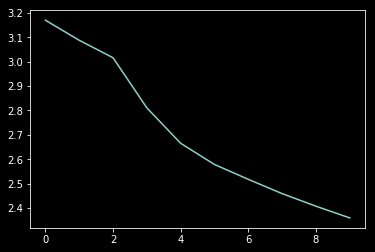

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.plot(model_train.history.history['loss'])

In [21]:
# Save model if necessary
model_train.save("keras-startrek-LSTM-model.h5")

## Test the Model

- Take a quote then add 400 characters.

### Make a Decoder model

- Needs input length of 1.
- Needs batch size of 1
- Needs LSTM to be stateful
- check that params is the same as model_train

In [22]:
# Load model if necessary.
model_train = load_model("keras-startrek-LSTM-model.h5")

In [23]:
# Build a decoding model (input length 1, batch size 1, stateful)

model_dec = Sequential()
model_dec.add(Embedding(vocabulary_size, layer_size, input_length=1, batch_input_shape=(1,1)))

# LSTM part
model_dec.add(LSTM(layer_size, stateful=True, return_sequences=True))
model_dec.add(LSTM(layer_size, stateful=True))

# project back to vocabulary
model_dec.add(Dense(vocabulary_size, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_dec.summary()

# set weights from training model
model_dec.set_weights(model_train.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, 1, 128)               6272      
_________________________________________________________________
lstm_7 (LSTM)                (1, 1, 128)               131584    
_________________________________________________________________
lstm_8 (LSTM)                (1, 128)                  131584    
_________________________________________________________________
dense_4 (Dense)              (1, 49)                   6321      
Total params: 275,761
Trainable params: 275,761
Non-trainable params: 0
_________________________________________________________________


In [24]:
## Sampling function

def sample_model(seed, model_name, length=400):
    '''Samples a charRNN given a seed sequence.'''
    generated = ''
    sentence = seed.lower()[:]
    generated += sentence
    print("Seed: ", generated)
    
    for i in range(length):
        x = np.array([char_indices[n] for n in sentence])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, 0.5)
        next_char = indices_char[next_index]
        
        generated += next_char
        sentence = sentence[1:] + next_char
    print("Generated: ", generated)

In [25]:
# Sample 1000 characters from the model using a random seed from the vocabulary.
sample_model(indices_char[random.randint(0,vocabulary_size-1)], model_dec, 1000)

Seed:  r
Generated:  rnon
ond the same
mond sil san
fere
the cert re
the wese
the bete ant in
the incone
the memet on
the the the the malation s
phint on
the the on fent an
the the dore
the ons
seten
the bolt of in
methe mane
sod anm
mespont
the cont con
the pone ther
the lendi
an ontin
the ceron
the wat on
the ant mare
fis af ot on
the ons to fore
the soge
bonde
catte
the onme
the the rerois tr
the post on
the pos anes
sos o the seridil
sine
the merit on
the patar
the the poncon
the the perat on
the efety
the simet in
the fare
the lolat on
the the les ol
shose mon te
the penty
me the reme tor
the ane
emend
the moas
tome
satte
ontin sonhe
the se lourg
vert
the ante
sheress
the ithe
seime
the ine
the tont on
te piut an
ont int on
the ense
the mereti
the deout in
shon
the emesc
the afedim
the pat on
the bof if (ne
the mothe
serent ar
the af tar
the beut on l
the on ot on ome tars
tare
the wet at on
the of mort tiot on
the on on the weme
the on the pere
the ser
the the mare son
the conte


## Experiments - Model Maker

A single function to make both training and running models.

In [ ]:
def model_maker(model, layer_size=64, dropout_rate=0.5, num_layers=1, vocab_size=20, input_length=1, lr=0.01, train_mode=True):
    """Builds a charRNN model with variable layer size, number of layers, droupout, learning rate, and a training mode."""
    if train_mode:
        stateful = False
        input_shape = (None, input_length)
    else:
        stateful = True
        input_shape = (1, input_length)
    
    # Input embedding
    model.add(Embedding(vocab_size, layer_size, input_length=input_length, batch_input_shape=input_shape))
              
    # LSTM layers + 1
    for i in range(num_layers - 1):
        model.add(Dropout(dropout_rate))
        model.add(LSTM(layer_size, return_sequences=True, stateful=stateful))
    
    # Final LSTM layer
    model.add(Dropout(dropout_rate))
    model.add(LSTM(layer_size, stateful=stateful))

    # Project back to vocabulary
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=lr))
    model.summary()

# m = Sequential()
# model_maker(m, layer_size=128, vocab_size=vocabulary_size, input_length=30, train_mode=True)
# m.fit(X, y, batch_size=64, epochs=5)